# Notebook reference parametrisation modèle trou carrés 2D 

Dans ce notebook sera calculé la solution de référence pour le modèle à trou carrés en 2D présenté plus bas. La paramétrisation est éxprimée graphiquement dans les figures plus bas. La mise en équation se fait ici de manière analytique, tout comme la construction du système linéaire pour le problème d'optimization linéaire. Le paramétrage des lois et autres paramètres importants sera défini ici.  

#### Equations des défauts des points hauts et bas des surfaces avec défauts des pièces. 

\begin{equation}
    \begin{aligned}
        X_{ih} &= X_i + u_i - a_i \cdot \frac{h}{2} \\ 
        X_{ib} &= X_i + u_i + a_i \cdot \frac{h}{2} \\ 
        Y_{ih} &= Y_i + v_i - b_i \cdot \frac{h}{2} \\ 
        Y_{ib} &= Y_i + v_i + b_i \cdot \frac{h}{2} \\ 
    \end{aligned}
\end{equation} 

<div>
<center><img src="../SCHEMAS/TCarres2DDims.png" width="650"/></center>
</div>
Sur cette première figure se trouvent les dimensions du problème. Chaque dimension est de $\pm 0.05$, avec donc un interval de tolérance $t=0.1$. 


<div>
<center><img src="../SCHEMAS/TCarres2DGapPara.png" width="650"/></center>
</div>


<div>
<center><img src="../SCHEMAS/TCarres2DDimsDefPara.png" width="650"/></center>
</div>

#### Système d'équations gouvernant le fonctionnement du système. 
\begin{equation}
    \begin{cases}
        Y_{1h} - J_{1h} - X_{1h} + X_{4h} - J_{4h} - Y_{4h} = 0 \\
        Y_{2h} + J_{2h} - X_{2h} + X_{3h} + J_{3h} - Y_{3h} = 0 \\
        Y_{1b} - J_{1b} - X_{1b} + X_{4b} - J_{4b} + Y_{4b} = 0 \\
        Y_{2b} + J_{2b} - X_{2b} + X_{3b} + J_{3b} - Y_{3b} = 0 \\
        Y_{1b} - J_{1b} - X_{1b} + X_{1h} + J_{1h} - Y_{1h} = 0 \\
        Y_{1b} - J_{1b} - X_{1b} + X_{2b} - J_{2b} - Y_{2b} = 0 \\
        Y_{1h} - J_{1h} - X_{1h} + X_{2h} - J_{2h} - Y_{2h} = 0 \\
    \end{cases}
\end{equation} 

$$ J_{ip} \geq 0$$

C'est sur celui-ci que se base la construction du système d'équations linéaires suivant: 
\begin{equation}
    \begin{bmatrix}
    -1 & 0  & 0 & -1 & 0 & 0 & 0 & 0 \\
    0  & 1  & 1 & 0  & 0 & 0 & 0 & 0 \\
    0  & 0  & 0 & 0  & -1 & 0 & 0 & -1 \\
    0  & 0  & 0 & 0  & 0 & 1 & 1 & 0 \\
    -1 & 0  & 0 & 0  & 1 & 0 & 0 & 0 \\
    -1 & -1 & 0 & 0  & 0 & 0 & 0 & 0 \\
    0  & 0  & 0 & 0  & -1 & -1 & 0 & 0
    \end{bmatrix} \cdot
    \begin{bmatrix}
    J_{1b} \\
    J_{2b}  \\
    J_{3b}  \\
    J_{4b}  \\
    J_{1h}  \\
    J_{2h}  \\
    J_{3h}  \\
    J_{4h}
    \end{bmatrix}
    +
    \begin{bmatrix}
    Y_{1b} - X_{1b} + X_{4b} - Y_{4b} \\
    Y_{2b} - X_{2b} + X_{3b} - Y_{3b} \\
    Y_{1h} - X_{1h} + X_{4h} - Y_{4h} \\
    Y_{2h} - X_{2h} + X_{3h} - Y_{3h} \\
    Y_{1b} - X_{1b} + X_{1h} - Y_{1h} \\
    Y_{1b} - X_{1b} + X_{2b} - Y_{2b} \\
    Y_{1h} - X_{1h} + X_{2h} - Y_{2h}
    \end{bmatrix}
    =
    0
\end{equation}

In [1]:
# Imports nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openturns as ot
from joblib import Parallel, delayed
from functools import partial
import itertools

# BILBIO DE BASE POUR LA PROG LINÉAIRE (resolution de système)
from scipy.optimize import linprog
from tqdm import trange
import tqdm

In [2]:
# Données modèle :
X1 = 24.9
X2 = 35.1
X3 = 94.9
X4 = 105.1

Y1 = 25
Y2 = 35
Y3 = 95
Y4 = 105

data = {
    "X1": 24.9,
    "X2": 35.1,
    "X3": 94.9,
    "X4": 105.1,
    "Y1": 25,
    "Y2": 35,
    "Y3": 95,
    "Y4": 105,
}

h = 10

# Données tolérances t est l'intervale de tolérance
t = 0.1

# Bornes max et min du jeu pour l'optimisation linéaire
borne_inf_jeu = 0
borne_sup_jeu = 20 * t


def compute_positions(H_i, u_i, a_i, inv=False):
    """Function returning the new positions for a dimension of the model.
    H_i = X or Y
    u_i : positional error
    v=a_i : orientation error
    """
    if inv:
        H_ih = H_i - u_i - (a_i * h / 2)
        H_ib = H_i - u_i + (a_i * h / 2)
    else:
        H_ih = H_i + u_i - (a_i * h / 2)
        H_ib = H_i + u_i + (a_i * h / 2)
    return H_ih, H_ib


def get_b_eq_from_errs(u1, a1, u2, a2, u3, a3, u4, a4, v1, b1, v2, b2, v3, b3, v4, b4):
    """Returns the equality constraint vector for the linear
    optimization problem.
    """
    X1h, X1b = compute_positions(X1, u1, a1)
    X2h, X2b = compute_positions(X2, u2, a2, inv=True)
    X3h, X3b = compute_positions(X3, u3, a3)
    X4h, X4b = compute_positions(X4, u4, a4, inv=True)

    Y1h, Y1b = compute_positions(Y1, v1, b1, inv=True)
    Y2h, Y2b = compute_positions(Y2, v2, b2)
    Y3h, Y3b = compute_positions(Y3, v3, b3, inv=True)
    Y4h, Y4b = compute_positions(Y4, v4, b4)

    B_eq = np.array(
        [
            Y1b - X1b + X4b - Y4b,
            Y2b - X2b + X3b - Y3b,
            Y1h - X1h + X4h - Y4h,
            Y2h - X2h + X3h - Y3h,
            Y1b - X1b + X1h - Y1h,
            Y1b - X1b + X2b - Y2b,
            Y1h - X1h + X2h - Y2h,
        ]
    )
    return B_eq


# Matrix defined in the introduction for the optimzation
A_eq = np.array(
    [
        [-1, 0, 0, -1, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, -1, 0, 0, -1],
        [0, 0, 0, 0, 0, 1, 1, 0],
        [-1, 0, 0, 0, 1, 0, 0, 0],
        [-1, -1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, -1, -1, 0, 0],
    ]
)

# There are 8 gaps, so 8 bounds to define.
# bounds = [(borne_inf_jeu,borne_sup_jeu), (-0.5,0.5)]*4 #bound for translation and rotation alternatively
# bounds only for gap, so only positive!!!
bounds = [(borne_inf_jeu, borne_sup_jeu)] * 8

# Method for the optimisation
method = "highs-ds"

In [3]:
# Définition des paramètres des lois de probabilités
Cm = 0.3
# The values for the stds is choosen in case where only one defect is present
sigma_e_pos = t / (6 * Cm)
theta_max = t / h
sigma_e_theta = (2 * theta_max) / (6 * Cm)

In [4]:
# Maintenant il nous faut une fonction nous renvoyant les lois de probabilités en fonction
# des paramètres lambda.


def get_composed_distribution_from_lambda(
    lambda_X_1,
    lambda_X_2,
    lambda_X_3,
    lambda_X_4,
    lambda_Y_1,
    lambda_Y_2,
    lambda_Y_3,
    lambda_Y_4,
):
    """This function returns a openturns.ComposedDistribution object,
    which represents the vector of positional and angular defects.
    By getting realizations from it we can generate defects.
    """
    ot.RandomGenerator.SetSeed(8888)
    e_pos_X_1 = lambda_X_1 * ot.Normal(0, sigma_e_pos)
    e_ori_X_1 = (1 - lambda_X_1) * ot.Normal(0, sigma_e_theta)
    e_pos_X_2 = lambda_X_2 * ot.Normal(0, sigma_e_pos)
    e_ori_X_2 = (1 - lambda_X_2) * ot.Normal(0, sigma_e_theta)
    e_pos_X_3 = lambda_X_3 * ot.Normal(0, sigma_e_pos)
    e_ori_X_3 = (1 - lambda_X_3) * ot.Normal(0, sigma_e_theta)
    e_pos_X_4 = lambda_X_4 * ot.Normal(0, sigma_e_pos)
    e_ori_X_4 = (1 - lambda_X_4) * ot.Normal(0, sigma_e_theta)
    e_pos_Y_1 = lambda_Y_1 * ot.Normal(0, sigma_e_pos)
    e_ori_Y_1 = (1 - lambda_Y_1) * ot.Normal(0, sigma_e_theta)
    e_pos_Y_2 = lambda_Y_2 * ot.Normal(0, sigma_e_pos)
    e_ori_Y_2 = (1 - lambda_Y_2) * ot.Normal(0, sigma_e_theta)
    e_pos_Y_3 = lambda_Y_3 * ot.Normal(0, sigma_e_pos)
    e_ori_Y_3 = (1 - lambda_Y_3) * ot.Normal(0, sigma_e_theta)
    e_pos_Y_4 = lambda_Y_4 * ot.Normal(0, sigma_e_pos)
    e_ori_Y_4 = (1 - lambda_Y_4) * ot.Normal(0, sigma_e_theta)

    defect_distributions = ot.ComposedDistribution(
        [
            e_pos_X_1,
            e_ori_X_1,
            e_pos_X_2,
            e_ori_X_2,
            e_pos_X_3,
            e_ori_X_3,
            e_pos_X_4,
            e_ori_X_4,
            e_pos_Y_1,
            e_ori_Y_1,
            e_pos_Y_2,
            e_ori_Y_2,
            e_pos_Y_3,
            e_ori_Y_3,
            e_pos_Y_4,
            e_ori_Y_4,
        ]
    )
    defect_distributions.setDescription(
        [
            "e_pos_X_1",
            "e_ori_X_1",
            "e_pos_X_2",
            "e_ori_X_2",
            "e_pos_X_3",
            "e_ori_X_3",
            "e_pos_X_4",
            "e_ori_X_4",
            "e_pos_Y_1",
            "e_ori_Y_1",
            "e_pos_Y_2",
            "e_ori_Y_2",
            "e_pos_Y_3",
            "e_ori_Y_3",
            "e_pos_Y_4",
            "e_ori_Y_4",
        ]
    )
    return defect_distributions


class SolveLinearSystem(ot.OpenTURNSPythonFunction):
    def __init__(self):
        super(SolveLinearSystem, self).__init__(16, 1)
        self.setInputDescription(
            [
                "e_pos_X_1",
                "e_ori_X_1",
                "e_pos_X_2",
                "e_ori_X_2",
                "e_pos_X_3",
                "e_ori_X_3",
                "e_pos_X_4",
                "e_ori_X_4",
                "e_pos_Y_1",
                "e_ori_Y_1",
                "e_pos_Y_2",
                "e_ori_Y_2",
                "e_pos_Y_3",
                "e_ori_Y_3",
                "e_pos_Y_4",
                "e_ori_Y_4",
            ]
        )
        self.setOutputDescription(["SUCCESS"])
        self.result = None

    def _exec(self, X):
        u1, a1, u2, a2, u3, a3, u4, a4, v1, b1, v2, b2, v3, b3, v4, b4 = X
        b_eq = get_b_eq_from_errs(
            u1, a1, u2, a2, u3, a3, u4, a4, v1, b1, v2, b2, v3, b3, v4, b4
        )
        c = [-1, 0, 0, 0, 0, 0, 0, 0]
        RES = linprog(c, A_eq=A_eq, b_eq=-1 * b_eq, bounds=bounds, method=method)
        self.result = RES
        return [int(RES.success), RES]


def get_failure_prob_MC(lambdas, sizeMC=1e4, seedMC=9999):
    ot.RandomGenerator.SetSeed(seedMC)
    defect_distributions = get_composed_distribution_from_lambda(*lambdas)
    sampleMC = defect_distributions.getSample(int(sizeMC))
    ot_model = SolveLinearSystem()
    results = [ot_model(point)[0] for point in sampleMC]
    failure_prob = 1 - sum(results) / len(results)
    return failure_prob


def get_imprecise_failure_probs(
    lambdaDOE,
    parallel=True,
):
    """The lambdaDOE is the design of experiment over the imprecise space
    of unknown defect allocation
    """
    f = get_failure_prob_MC
    if parallel:
        return Parallel(n_jobs=-3, verbose=5)(
            delayed(f)(lambdas) for lambdas in lambdaDOE
        )
    else:
        return [f(lambdas) for lambdas in tqdm.tqdm(lambdaDOE)]

In [5]:
lambdaDistElementar = ot.Uniform(0, 1)
lambdasDist = ot.ComposedDistribution([lambdaDistElementar] * 8)

# Sampling of lambdas using LHS
# Random LHS of size 500
N = 500
lhs = ot.LHSExperiment(lambdasDist, N)
lhs.setAlwaysShuffle(True)  # randomized
design = lhs.generate()

In [6]:
failure_probs_MC = get_imprecise_failure_probs(design, True)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=-3)]: Done  36 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-3)]: Done 126 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done 252 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-3)]: Done 414 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-3)]: Done 500 out of 500 | elapsed:  4.7min finished


In [7]:
print("Lower probability of failure:", round(min(failure_probs_MC) * 100, 4), "%")
print("Upper probability of failure:", round(max(failure_probs_MC) * 100, 4), "%")

Lower probability of failure: 7.95 %
Upper probability of failure: 23.81 %


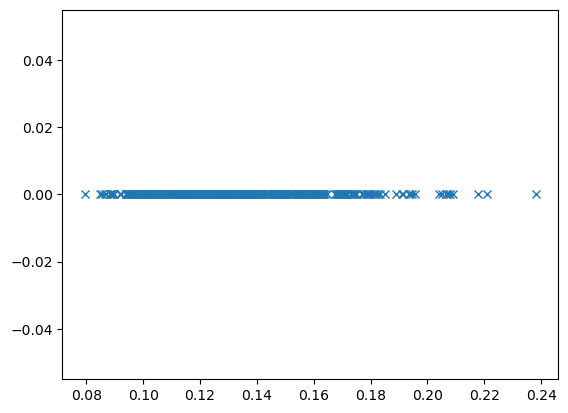

In [8]:
plt.plot(failure_probs_MC, np.zeros_like(failure_probs_MC) + 0, "x")
plt.show()

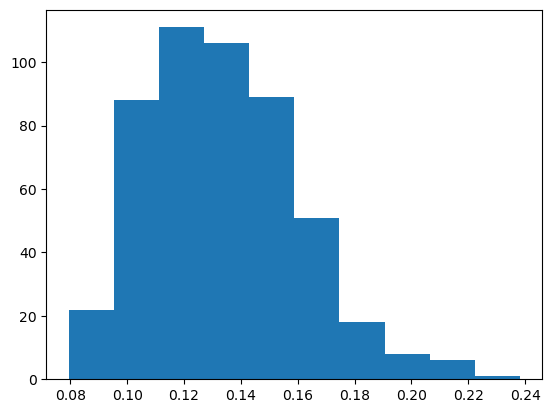

In [9]:
plt.hist(failure_probs_MC)
plt.show()